# Preprocessing Of Household Survey Data

In this Python notebook, we will perform a final preprocessing of the household data for both country, Tanzania and Uganda. The aim of this work to check the 


[Spatial Interpolation](https://pygis.io/docs/e_interpolation.html)(retrieved 25th April 2024)

## Import Libraries

In this section, we import essential libraries and modules required for data preprocessing, analysis, and visualization tasks. These libraries provide robust functionalities and tools that streamline the data analysis workflow and enable us to manipulate and explore the dataset efficiently.

In [2]:
import pandas as pd
from pandas import read_csv
import numpy as np
import seaborn as sns
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import plotly.express as px

## <a id='helper_function'></a> Helper Function

In this section we define a set of helper functions designed to facilitate common data preprocessing tasks essential for maintaining the integrity and quality of the dataset. These functions assist in various steps of the data preparation process such as checking for missing values, data interpolation, data distribution and other tasks,ensuring the data is clean,well-understood and properly structured before further analysis and model training.

In [2]:
def checking_missing_value(df):
    # Check for missing values
    missing_values = df.isnull().sum()
    if missing_values.sum() > 0:
        print("Missing values found in the dataset:")
        print(missing_values)
    else:
        print("No missing values found in the dataset.")

    return df

In [3]:
def concat_and_save_to_csv(df_list, file_name='concatenated_data.csv'):
    """
    Concatenates a list of DataFrames into a single DataFrame and saves it to a CSV file.

    Parameters:
        df_list (list): List of DataFrames to concatenate.
        file_name (str): Name of the CSV file to save the concatenated DataFrame. Default is 'concatenated_data.csv'.
    """
    # Concatenate the DataFrames
    concatenated_df = pd.concat(df_list, ignore_index=True)

    # Save the concatenated DataFrame to a CSV file
    concatenated_df.to_csv(file_name, index=False)

    print(f"Concatenated DataFrame saved to {file_name}")

In [5]:
def checking_classification_thresholds(df, column='fcs'):
    """
    Prints classification thresholds based on percentiles of a column in a DataFrame.

    Parameters:
        df (DataFrame): The DataFrame for which to print classification thresholds.
        column (str): The name of the column used for computing thresholds. Default is 'fcs'.
    """
    # Calculate the percentiles with one decimal place
    lower_bound = np.round(np.percentile(df[column], 33.33), 1)
    upper_bound = np.round(np.percentile(df[column], 66.67), 1)
    
    # Print classification thresholds
    print(f"FCS Thresholds:\n"
          f"  - Poor: < {lower_bound}\n"
          f"  - Borderline: {lower_bound} - {upper_bound}\n"
          f"  - Acceptance: >= {upper_bound}")

In [20]:
def assign_class(df, column_name, thresholds):
    """
    Assigns a class to each row in the DataFrame based on the specified column and custom thresholds.

    Parameters:
        df (DataFrame): The DataFrame to which the class will be assigned.
        column_name (str): The name of the column used for classification.
        thresholds (dict): A dictionary containing custom lower and upper bounds for classification.
                           Example: {'Poor': (lower_bound_poor, upper_bound_poor),
                                     'Borderline': (lower_bound_borderline, upper_bound_borderline)}

    Returns:
        DataFrame: The original DataFrame with additional columns 'fcg' and 'class' assigned.
    """
    # Sort the thresholds by the lower bound
    sorted_thresholds = sorted(thresholds.items(), key=lambda x: x[1][0])
    
    # Define classification function based on custom thresholds
    def classify(value):
        for i, (label, (lower, upper)) in enumerate(sorted_thresholds, start=1):
            if value < lower:
                return 'Poor', i
            elif lower <= value < upper:
                return 'Borderline', i
        return 'Acceptance', i + 1
    
    # Apply classification function to the specified column
    df['fcg'], df['class'] = zip(*df[column_name].apply(classify))
    
    return df

In [48]:
def assign_class(df, column_name, thresholds):
    """
    Assigns a class to each row in the DataFrame based on the specified column and custom thresholds.

    Parameters:
        df (DataFrame): The DataFrame to which the class will be assigned.
        column_name (str): The name of the column used for classification.
        thresholds (dict): A dictionary containing custom lower and upper bounds for classification.
                           Example: {'Poor': (lower_bound_poor, upper_bound_poor),
                                     'Borderline': (lower_bound_borderline, upper_bound_borderline)}

    Returns:
        DataFrame: The original DataFrame with additional columns 'fcg' and 'class' assigned.
    """
    # Sort the thresholds by the lower bound
    sorted_thresholds = sorted(thresholds.items(), key=lambda x: x[1][0])
    
    # Define classification function based on custom thresholds
    def classify(value):
        for label, (lower, upper) in sorted_thresholds:
            if value < lower:
                return label, 1  # Assume 'Poor' is always the first category
            elif lower <= value < upper:
                return label, sorted_thresholds.index((label, (lower, upper))) + 1
        return 'Acceptance', len(sorted_thresholds) + 1  # For values above all defined thresholds
    
    # Apply classification function to the specified column
    df['fcg'], df['class'] = zip(*df[column_name].apply(classify))
    
    return df

## Unused Functions Need To Delete Later on!

In [9]:
def integrate_shapefile_data(df, gdf, additional_columns=None):
    
    '''
    Integrates data from a DataFrame with region and district information available in a shapefile.

    Args:
        df (DataFrame): The DataFrame containing the dataset to be integrated.
        gdf (DataFrame): The DataFrame containing region and district information.

    Returns:
        DataFrame: The integrated DataFrame with missing districts

    '''
   

    # Combine 'region' and 'district' to form a unique identifier
    gdf['region_district'] = gdf['region'] + '_' + gdf['district']
    df['region_district'] = df['region'] + '_' + df['district']

    # Find missing region-district combinations
    missing_combinations = set(gdf['region_district']) - set(df['region_district'])

    missing_combinations_count = len(missing_combinations)
    if missing_combinations_count > 0:
        print(f"{missing_combinations_count} region-district combinations were not covered in this survey.")

        # Extract missing districts and regions from missing_combinations
        missing_districts = [combo.split('_')[1] for combo in missing_combinations]
        missing_regions = [combo.split('_')[0] for combo in missing_combinations]

        # Add missing values to the original DataFrame
        missing_data = pd.DataFrame({'district': missing_districts, 'region': missing_regions})
        missing_data['year'] = df['year'].iloc[0]  # Use the first value of 'year' from the original DataFrame
        for col in ['fcs', 'hdds', 'count']:
            missing_data[col] = None

        # Concatenate missing data with the original DataFrame
        df = pd.concat([df, missing_data], ignore_index=True)

    # Drop the 'region_district' column
    df = df.drop(columns=['region_district'])

    return df

In [10]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from scipy.spatial import cKDTree

def spatial_interpolation(df, shapefile_path, radius=0.1, k=3):
    # Read shapefile
    gdf = gpd.read_file(shapefile_path)

    # Merge DataFrame and GeoDataFrame based on 'region' and 'district'
    merged_df = pd.merge(df, gdf[['region', 'district', 'geometry']], on=['region', 'district'], how='left')

    # Create a spatial index for fast spatial queries
    tree = cKDTree(merged_df[['geometry']].apply(lambda x: x.centroid.coords[0], axis=1))

    # Perform spatial interpolation for missing values
    for idx, row in merged_df[merged_df.isnull().any(axis=1)].iterrows():
        if pd.isnull(row['fcs']):
            # Find nearby points within the radius
            idxs = tree.query_ball_point(row['geometry'].centroid.coords[0], radius)
            nearby_points = merged_df.iloc[idxs].dropna(subset=['fcs'])

            # Interpolate missing 'fcs' value based on k-nearest neighbors
            if not nearby_points.empty:
                nearest_neighbors = nearby_points.nsmallest(k, 'geometry', keep='all')
                merged_df.at[idx, 'fcs'] = nearest_neighbors['fcs'].mean()

        # Similarly, perform interpolation for 'hdds' and 'count' columns

    # Drop unnecessary columns and return the interpolated DataFrame
    interpolated_df = merged_df.drop(columns=['geometry'])
    return interpolated_df

# Example usage:
# Assuming 'data' is your DataFrame containing the dataset
# data = pd.read_csv('your_dataset.csv')
# shapefile_path = 'path_to_your_shapefile.shp'
# interpolated_data = spatial_interpolation(data, shapefile_path)


## Visualization Function

In this section of the notebook, we are creating variety of visualization functions that will effectively illustrate and explore the underlying data. These visualizations will offer insightful perspectives on the dataset, enabling clear interpretation and analysis of our data visually by examining trends, distributions,correlation and spatial relationships. We will create basic plots like histograms and scatter plots to more advanced visualizations such as heatmaps and interactive charts.....

In [18]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

def plot_fcs_distribution(shapefile_path, data_df, title):
    """
    Plots a map based on the Food Consumption Score (FCS).
    
    Parameters:
    - shapefile_path: Path to the district shapefile.
    - data_path: Path to the CSV file containing district names and FCS.
    - title: Title for the plot.
    """
    # Load the shapefile
    gdf = gpd.read_file(shapefile_path)
    
    # Load the data
    #data_df = pd.read_csv(data_path)
    
    # Define FCS categories
    bins = [0, 50.5, 59.5, float('inf')]
    labels = ['Poor', 'Borderline', 'Acceptance']
    data_df['FCS_Category'] = pd.cut(data_df['fcs'], bins=bins, labels=labels, right=False)
    
    # Merge the GeoDataFrame with the data DataFrame
    gdf = gdf.merge(data_df, left_on='district', right_on='district', how='left')
    
    # Set color mapping
    cmap = {'Poor': '#ffcccc', 'Borderline': '#ffe5cc', 'Acceptance': '#ccffcc'}
    
    # Plotting
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    for category, color in cmap.items():
        subset = gdf[gdf['FCS_Category'] == category]
        subset.plot(ax=ax, label=category, color=color)
    
    # Customizations
    ax.set_title(title)
    ax.set_axis_off()  # Hide axes
    plt.legend(title='FCS Group')
    plt.show()


## Final Processing of Tanzania Data 

#### Merge the All Dataset Files into A Single File

In [22]:
#define data directory
tz_dir = 'Tanzania/data/'

#load the data files
df1 = read_csv(tz_dir + 'tz_2010_2011_final.csv', delimiter = ',')
df2 = read_csv(tz_dir + 'tz_2012_2013_final.csv', delimiter = ',')
df3 = read_csv(tz_dir + 'tz_2014_2015_final.csv', delimiter = ',')
df4 = read_csv(tz_dir + 'tz_2019_2020_final.csv', delimiter = ',')
df5 = read_csv(tz_dir + 'tz_2020_2022_final.csv', delimiter = ',')
df6 = read_csv(tz_dir + 'tz_2023_final.csv', delimiter = ',')

#create a list of dataframes
df_list = [df1, df2, df3, df4, df5, df6]

#call a function to merge the files
#concat_and_save_to_csv(df_list, file_name='Tanzania/data/all_tz_data.csv')

#### Checking the Lower and Upper bound to classify the FCS

In [49]:
#load the merged file
data = read_csv(tz_dir + 'all_tz_data.csv', delimiter = ',')
data.tail()

,year,region,district,fcs,hdds,count
878,2023,Tanga,Korogwe Town,20.50,4.00,1
879,2023,Tanga,Lushoto,62.43,8.43,7
880,2023,Tanga,Muheza,74.33,8.33,6
881,2023,Tanga,Pangani,67.25,8.25,4
882,2023,Tanga,Tanga,79.33,8.50,6


In [50]:
checking_classification_thresholds(data)

FCS Thresholds:
  - Poor: < 50.6
  - Borderline: 50.6 - 59.3
  - Acceptance: >= 59.3


#### Assign Classes based on threshold

The threshold are like FCS Thresholds:
  - Poor: < 50.6
  - Borderline: 50.6 - 59.3
  - Acceptance: >= 59.3
  
Let then modify a litle bit then we make like:
  - Poor: < 50.5
  - Borderline: 50.5 - 59.5
  - Acceptance: >= 59.5

In [51]:
thresholds = {'Poor': (0, 50.5), 'Borderline': (50.5, 59.5)}
data_final = assign_class(data, 'fcs', thresholds)

In [52]:
data_final.head()

,year,region,district,fcs,hdds,count,fcg,class
0,2010/2011,Arusha,Arusha,65.29,8.14,7,Acceptance,3
1,2010/2011,Arusha,Arusha Urban,68.51,8.38,40,Acceptance,3
2,2010/2011,Arusha,Karatu,52.47,7.40,15,Borderline,2
3,2010/2011,Arusha,Meru,69.47,8.15,20,Acceptance,3
4,2010/2011,Arusha,Monduli,52.05,6.16,19,Borderline,2


In [55]:
data_final['fcg'].value_counts()

fcg
Borderline    304
Poor          292
Acceptance    287
Name: count, dtype: int64

In [56]:
data_final['class'].value_counts()

class
2    304
1    292
3    287
Name: count, dtype: int64

In [57]:
#save the final data
data_final.to_csv(tz_dir+ 'final_data/tz_data_final.csv', index=False)

### Visualizing

In [58]:
district_shp = tz_dir + 'tz_districts.shp'

<Axes: >

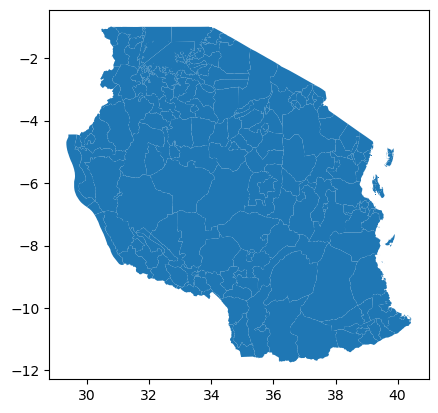

In [60]:
gdf = gpd.read_file(district_shp)
gdf.plot()

C:\Users\ashas\AppData\Local\Temp\ipykernel_20300\4222258111.py:40: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(title='FCS Group')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


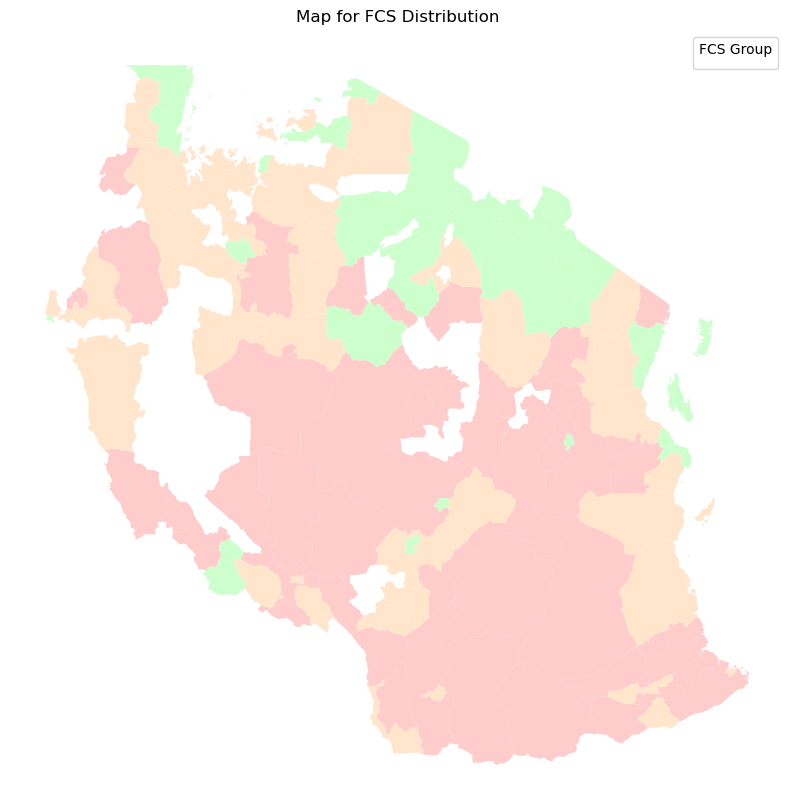

In [61]:
title= 'Map for FCS Distribution'
plot_fcs_distribution(district_shp, df2, title)

## ## Final Processing of Rwanda Data 

#### Merge the All Dataset Files into A Single File

In [63]:
#define data directory
rw_dir = 'Rwanda/data/'

#load data
df1 = read_csv(rw_dir + 'rw_2006_final.csv', delimiter = ',')
df2 = read_csv(rw_dir + 'rw_2012_final.csv', delimiter = ',')
df3 = read_csv(rw_dir + 'rw_2015_final.csv', delimiter = ',')
df4 = read_csv(rw_dir + 'rw_2018_final.csv', delimiter = ',')
df5 = read_csv(rw_dir + 'rw_2021_final.csv', delimiter = ',')

#dataframe list
df_list = [df1, df2, df3, df4, df5]

#merge the dataset in a single file
#concat_and_save_to_csv(df_list, file_name='Rwanda/data/all_rw_data.csv')

#### Checking the Lower and Upper bound to classify the FCS

In [64]:
data = read_csv(rw_dir + 'all_rw_data.csv', delimiter = ',')

In [55]:
data.head()

,year,province,district,fcs,hdds,count
0,2006,Amajyaruguru,Burera,34.11,3.71,59
1,2006,Amajyaruguru,Gakenke,42.05,4.15,61
2,2006,Amajyaruguru,Gicumbi,39.73,3.70,66
3,2006,Amajyaruguru,Musanze,37.83,4.05,108
4,2006,Amajyaruguru,Rulindo,44.52,4.54,46


In [65]:
checking_classification_thresholds(data)

FCS Thresholds:
  - Poor: < 42.1
  - Borderline: 42.1 - 47.1
  - Acceptance: >= 47.1


#### Assign Classes based on threshold

The threshold are like FCS Thresholds:
   - Poor: < 42.1
  - Borderline: 42.1 - 47.1
  - Acceptance: >= 47.1
  
Let then modify a litle bit then we make like:
  - Poor: < 42
  - Borderline: 42 - 47
  - Acceptance: >= 47

In [66]:
thresholds = {'Poor': (0, 42), 'Borderline': (42, 47)}
data_final = assign_class(data, 'fcs', thresholds)

In [67]:
data_final.head()

,year,province,district,fcs,hdds,count,fcg,class
0,2006,Amajyaruguru,Burera,34.11,3.71,59,Poor,1
1,2006,Amajyaruguru,Gakenke,42.05,4.15,61,Borderline,2
2,2006,Amajyaruguru,Gicumbi,39.73,3.70,66,Poor,1
3,2006,Amajyaruguru,Musanze,37.83,4.05,108,Poor,1
4,2006,Amajyaruguru,Rulindo,44.52,4.54,46,Borderline,2


#### Dataset of 2010 - 2011

In [68]:
data_final['fcg'].value_counts()

fcg
Acceptance    54
Borderline    49
Poor          44
Name: count, dtype: int64

In [69]:
data_final['class'].value_counts()

class
3    54
2    49
1    44
Name: count, dtype: int64

In [70]:
#save the final data
data_final.to_csv(rw_dir+ 'final_data/rw_data_final.csv', index=False)

In [9]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

def analyze_tiff(tiff_path):
    with rasterio.open(tiff_path) as src:
        # Get the number of bands
        num_bands = src.count
        
        # Get CRS, transform, and shape
        crs = src.crs
        transform = src.transform
        width = src.width
        height = src.height
        
        print(f"TIFF file CRS: {crs}")
        print(f"TIFF file Transform: {transform}")
        print(f"TIFF file Width: {width}, Height: {height}")
        print(f"Number of Bands: {num_bands}")
        
        # Analyze each band
        for band in range(1, num_bands + 1):
            data = src.read(band)
            print(f"\nBand {band} - Shape: {data.shape}")
            
            # Analyze the data distribution
            unique_values, counts = np.unique(data, return_counts=True)
            value_distribution = dict(zip(unique_values, counts))
            
            print("Value distribution in this band:")
            for value, count in value_distribution.items():
                print(f"Value: {value}, Count: {count}")
            
            # Display a sample of the values in the band
            sample_values = data[0:10, 0:10]  # Display a 10x10 sample
            print("Sample values from the band (10x10):")
            print(sample_values)
            
            # Plot the band data
            plt.figure(figsize=(10, 10))
            plt.imshow(data, cmap='viridis')
            plt.colorbar(label='Value')
            plt.title(f'Band {band} Data Visualization')
            plt.xlabel('Column Index')
            plt.ylabel('Row Index')
            plt.show()




TIFF file CRS: PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
TIFF file Transform: | 100.00, 0.00, 2890800.00|
| 0.00,-100.00,-129500.00|
| 0.00, 0.00, 1.00|
TIFF file Width: 2048, Height: 2216
Number of Bands: 1

Band 1 - Shape: (2216, 2048)
Value distribution in this band:
Value: 0, Count: 1993435
Value: 1, Count: 64989
Value: 2, Count: 70843
Value: 3, Count: 83377
Value: 4, Count: 51513
Value: 5, Count: 57112
Value: 6, Count: 67876
Value: 7, Count: 58494
Value: 8, Count: 66428
Value: 9, Count: 65109
Value: 10, Count: 109851
Value: 11, Count: 67593
Value: 12, Count: 101387
Value: 13, Count: 63015
Value: 14, Count: 130102
Value: 15, Count: 159481
Value: 1

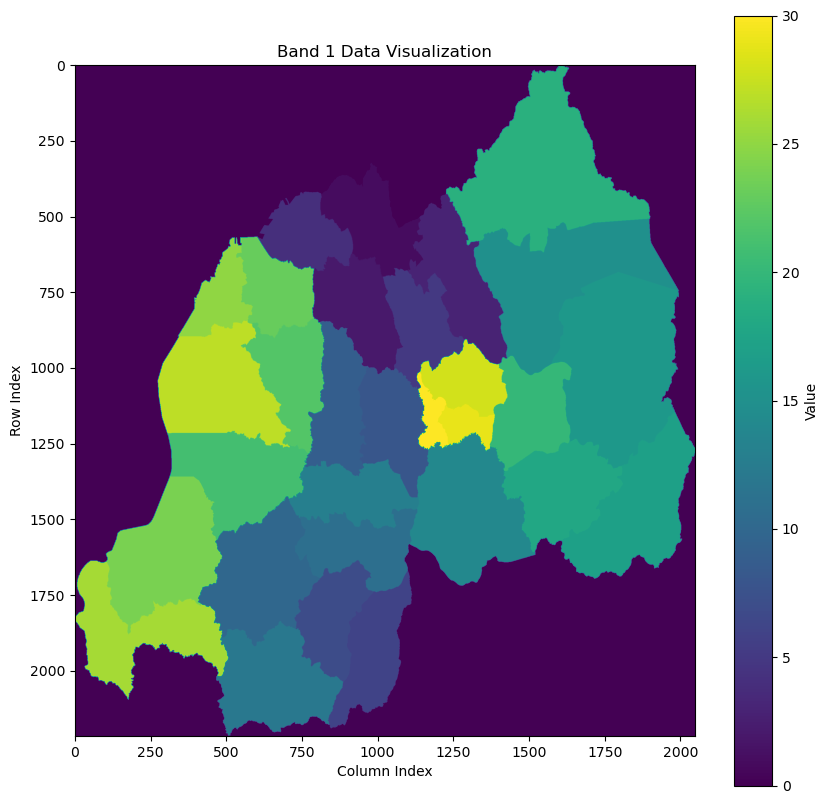

In [10]:
# Example usage
tiff_path = 'Rwanda/rasters/rw_district_id.tif'
analyze_tiff(tiff_path)

In [2]:
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
import numpy as np
import os

def create_raster_from_existing_tif(csv_file, shapefile, existing_tif, output_dir, prefix):
    try:
        # Load CSV data
        data = pd.read_csv(csv_file)

        # Load district shapefile
        gdf = gpd.read_file(shapefile)

        # Load existing TIFF to get the reference transform and metadata
        with rasterio.open(existing_tif) as src:
            transform = src.transform
            meta = src.meta
            bounds = src.bounds
            crs = src.crs
        
        # Check CRS and reproject if necessary
        if gdf.crs != crs:
            gdf = gdf.to_crs(crs)
            print(f"Reprojected shapefile from {gdf.crs} to {crs}")

        # Ensure the CSV has 'district', 'fcs', 'hdds', and 'year' columns
        data = data[['district', 'fcs', 'hdds', 'year']]

        # Merge CSV data with shapefile data
        merged = gdf.merge(data, left_on='district', right_on='district')

        # Group data by year
        years = merged['year'].unique()

        # Initialize arrays to accumulate the sum of FCS and HDDS
        fcs_sum_array = np.zeros((meta['height'], meta['width']), dtype='float64')
        hdds_sum_array = np.zeros((meta['height'], meta['width']), dtype='float64')

        # Function to create raster for a given column and year
        def create_raster(gdf, column, year, prefix, output_dir):
            out_shape = (meta['height'], meta['width'])
            
            def generator():
                for geom, value in zip(gdf.geometry, gdf[column]):
                    yield geom, value

            raster = rasterize(
                generator(),
                out_shape=out_shape,
                fill=0,
                transform=transform,
                dtype='float64'
            )

            output_tif = os.path.join(output_dir, f'{prefix}_{year}_{column}.tif')

            meta.update({
                'count': 1,
                'dtype': 'float64',
                'transform': transform,
                'crs': crs
            })

            with rasterio.open(output_tif, 'w', **meta) as dst:
                dst.write(raster, 1)
            
            return raster

        # Create TIFF files for each year and each metric
        for year in years:
            gdf_year = merged[merged['year'] == year]
            
            # Create raster for FCS
            fcs_raster = create_raster(gdf_year, 'fcs', year, prefix, output_dir)
            fcs_sum_array += fcs_raster
            
            # Create raster for HDDS
            hdds_raster = create_raster(gdf_year, 'hdds', year, prefix, output_dir)
            hdds_sum_array += hdds_raster

        # Save the sum of FCS and HDDS rasters
        fcs_complete_tif = os.path.join(output_dir, f'{prefix}_complete_fcs.tif')
        hdds_complete_tif = os.path.join(output_dir, f'{prefix}_complete_hdds.tif')

        with rasterio.open(fcs_complete_tif, 'w', **meta) as dst:
            dst.write(fcs_sum_array, 1)

        with rasterio.open(hdds_complete_tif, 'w', **meta) as dst:
            dst.write(hdds_sum_array, 1)

        print("TIFF files created successfully, including complete FCS and HDDS sum files.")
        
    except Exception as e:
        print(f"An error occurred: {e}")

In [7]:
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
import os

def create_district_id_tif_from_excel(excel_file, shapefile, existing_tif, output_dir, prefix):
    try:
        # Load district data from Excel file
        excel_data = pd.read_excel(excel_file, sheet_name=0)
        
        # Ensure the Excel file has a 'district' column
        if 'district' not in excel_data.columns:
            raise ValueError("Excel file must contain 'district' column.")

        # Load district shapefile
        gdf = gpd.read_file(shapefile)
        
        # Ensure the shapefile has a 'district' column
        if 'district' not in gdf.columns:
            raise ValueError("Shapefile must contain 'district' column.")

        # Merge Excel data with shapefile data
        gdf = gdf.merge(excel_data, on='district')

        # Load existing TIFF to get the reference transform and metadata
        with rasterio.open(existing_tif) as src:
            transform = src.transform
            meta = src.meta
            crs = src.crs

        # Check CRS and reproject if necessary
        if gdf.crs != crs:
            gdf = gdf.to_crs(crs)
            print(f"Reprojected shapefile from {gdf.crs} to {crs}")

        # Ensure the shapefile has 'District_ID' column from the merged data
        if 'DISTRICT_ID' not in gdf.columns:
            raise ValueError("Merged data must contain 'DISTRICT_ID' column.")

        # Function to create raster with District_ID for each district
        def create_raster_with_id(gdf, output_tif):
            out_shape = (meta['height'], meta['width'])
            
            def generator():
                for geom, district_id in zip(gdf.geometry, gdf['DISTRICT_ID']):
                    yield geom, district_id

            raster = rasterize(
                generator(),
                out_shape=out_shape,
                fill=0,
                transform=transform,
                dtype='int32'
            )

            meta.update({
                'count': 1,
                'dtype': 'int32',
                'transform': transform,
                'crs': crs
            })

            with rasterio.open(output_tif, 'w', **meta) as dst:
                dst.write(raster, 1)

        # Create a single TIFF file with District_ID for each district
        output_tif = os.path.join(output_dir, f'{prefix}_district_id.tif')
        create_raster_with_id(gdf, output_tif)

        print("TIFF file with District_ID created successfully.")
        
    except Exception as e:
        print(f"An error occurred: {e}")


### RWANDA

In [8]:

csv_file = 'Rwanda/data/rw_all_data.csv'
shapefile = 'Rwanda/Shapefiles/rw_district.shp'
existing_tif = 'Rwanda/rw_2000_population_data.tif'
output_dir = 'Rwanda/rasters'
prefix = 'rw'

excel_file = 'Rwanda/rep_epa_2006-2021.xlsx'


create_district_id_tif_from_excel(excel_file, shapefile, existing_tif, output_dir, prefix)


#create_raster_from_existing_tif(csv_file, shapefile, existing_tif, output_dir, prefix)

Reprojected shapefile from PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]] to PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
TIFF file with District_ID created successfully.


#### TANZANIA

In [5]:
# Example usage
csv_file = 'Tanzania/data/tz_all_data.csv'
shapefile = 'Tanzania/tz_shapefiles/tz_districts.shp'
existing_tif = 'Tanzania/tz_2000_population_data.tif'
output_dir = 'Tanzania/rasters'
prefix = 'tz'
#create_raster_from_existing_tif(csv_file, shapefile, existing_tif, output_dir, prefix)

Reprojected shapefile from PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]] to PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
An error occurred: Attempt to create new tiff file 'Tanzania/rasters\tz_2010/2011_fcs.tif' failed: No such file or directory
